In [1]:
%load_ext autoreload
%autoreload 1
%aimport dlqmc.NN, dlqmc.Sampler, dlqmc.Examples, dlqmc.utils
%config InlineBackend.figure_format = 'svg' 
%config InlineBackend.print_figure_kwargs = \
    {'bbox_inches': 'tight', 'dpi': 300}

In [2]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, RandomSampler
from torch.distributions import Normal
from pyscf import gto, scf
from pyscf.data.nist import BOHR
from tqdm import tqdm, trange

from dlqmc.NN import WaveNet
from dlqmc.Sampler import HMC_ad
from dlqmc.Examples import Potential, Laplacian, Gradient, fit
from dlqmc.utils import (
    plot_func, local_energy, wf_from_mf, get_3d_cube_mesh
)

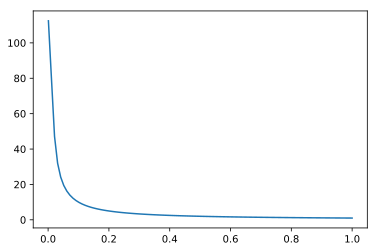

In [3]:
plot_func(np.linspace(1e-3, 1, 100), lambda x: special.erf(x/0.01)/x);

In [66]:
coords = torch.Tensor([[-1, 0, 0], [1, 0, 0]])
charges = torch.Tensor([1, 1])
x_line = torch.cat((torch.linspace(-3, 3, 500)[:, None], torch.zeros((500, 2))), dim=1)
mesh = get_3d_cube_mesh([(-6, 6), (-4, 4), (-4, 4)], [600, 400, 400])

In [5]:
mol = gto.M(
    atom=[
        ['H', (-1, 0, 0)],
        ['H', (1, 0, 0)]
    ],
    unit='bohr',
    basis='aug-cc-pv5z',
    charge=1,
    spin=1,
)
mf = scf.RHF(mol)
mf.kernel()

converged SCF energy = -0.602622271479772


-0.6026222714797722

## Net WF

In [4]:
#H2+     Energy = -0.6023424   for R = 1.9972
#fit(batch_size=10000, n_el=1, steps=500, epochs=1, RR=[[-1, 0, 0], [1., 0, 0]])

#H2		 Energy = -1.173427    for R = 1.40
#fit(batch_size=10000,n_el=2,steps=100,epochs=5,RR=torch.tensor([[-0.7,0,0],[0.7,0,0]]))

#He+	 Energy = -1.9998
#fit(batch_size=10000,n_el=1,steps=100,epochs=5,RR=torch.tensor([[0.,0,0]]),RR_charges=[2])

#He		 Energy = −2.90338583
#fit(batch_size=10000,n_el=2,steps=300,epochs=5,RR=torch.tensor([[0.3,0,0]]),RR_charges=[2])

In [5]:
lr = 5e-3

In [6]:
net = WaveNet([2, 20, 20, 20, 1], eps=0.01)
opt = torch.optim.Adam(net.parameters(), lr=lr)
tape = []
for i_step in trange(0, 1_000):
    r = 3*torch.randn(10_000, 3)
    grad_psi, psi = Gradient(r, coords, net)
    V = Potential(r, coords, charges)
    loss = torch.sum(0.5*torch.sum(grad_psi**2, dim=1) + V*psi**2)/torch.sum(psi**2)
    with torch.autograd.no_grad():
        tape.append((i_step, loss.item(), net(x_line, coords).squeeze()))
    loss.backward()
    opt.step()
    opt.zero_grad()

100%|██████████| 1000/1000 [00:37<00:00, 26.66it/s]


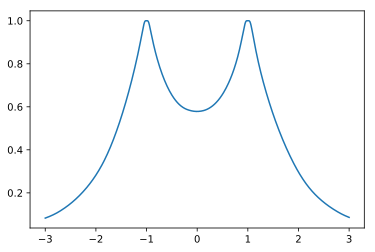

In [10]:
plt.plot(x_line[:, 0].numpy(), -net(x_line, coords).detach().numpy());

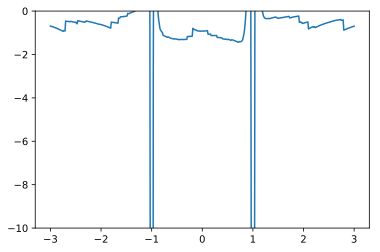

In [29]:
plt.plot(
    x_line[:, 0].numpy(),
    local_energy(lambda x: net(x, coords), x_line, coords, charges).detach().numpy()
)
plt.ylim((-10, 0));

In [30]:
samples = HMC_ad(
    dist=lambda x: net(x, coords).squeeze()**2,
    stepsize=0.1,
    dysteps=3,
    n_walker=100,
    steps=5000,
    dim=3,
    push=1,
    startfactor=1,
    presteps=50,
).detach().reshape(-1, 3)

Acceptanceratio: 87.12%


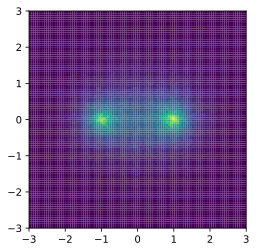

In [31]:
plt.hist2d(
    samples[:, 0].numpy(),
    samples[:, 1].numpy(),
    bins=100,
    range=[[-3, 3], [-3, 3]],
)                                   
plt.gca().set_aspect(1)

In [32]:
E_loc = local_energy(lambda x: net(x, coords), samples, coords, charges)

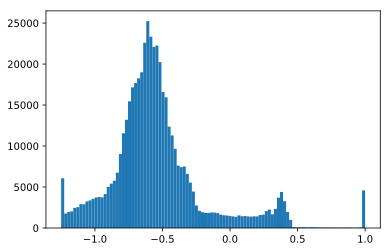

In [33]:
plt.hist(E_loc.detach().clamp(-1.25, 1).numpy(), bins=100);

In [35]:
E_loc.mean().item()

-0.5168347954750061

## GTO WF

In [6]:
mol = gto.M(
    atom=[
        ['H', (-1, 0, 0)],
        ['H', (1, 0, 0)]
    ],
    unit='bohr',
    basis='6-311g',
    charge=1,
    spin=1,
)
mf = scf.RHF(mol)
scf_energy = mf.kernel()

converged SCF energy = -0.590478992645746


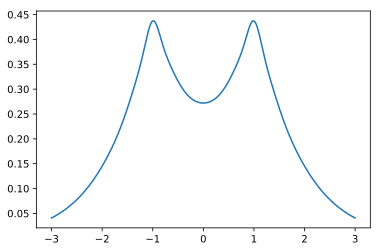

In [7]:
plt.plot(
    x_line[:, 0].numpy(),
    wf_from_mf(x_line, mf, 0).detach().numpy()
);

In [136]:
(wf_from_mf(mesh, mf, 0)**2).sum()*(12*8*8/mesh.shape[0])

tensor(0.9920)

(-10, 0)

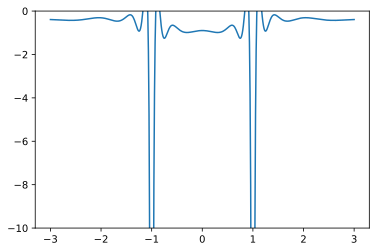

In [137]:
plt.plot(
    x_line[:, 0].numpy(),
    local_energy(
        x_line,
        lambda x: wf_from_mf(x, mf, 0),
        coords,
        charges,
    ).detach().numpy()
)
plt.ylim((-10, 0))

In [22]:
samples = HMC_ad(
    dist=lambda x: wf_from_mf(x, mf, 0)**2,
    stepsize=0.1,
    dysteps=3,
    n_walker=100,
    steps=5000,
    dim=3,
    push=1,
    startfactor=1,
    presteps=50,
).detach().reshape(-1, 3)

Acceptanceratio: 87.29%


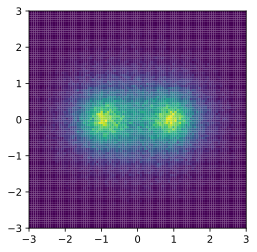

In [23]:
plt.hist2d(
    samples[:, 0].numpy(),
    samples[:, 1].numpy(),
    bins=100,
    range=[[-3, 3], [-3, 3]],
)                                   
plt.gca().set_aspect(1)

In [24]:
E_loc = local_energy(lambda x: wf_from_mf(x, mf, 0), samples, coords, charges)

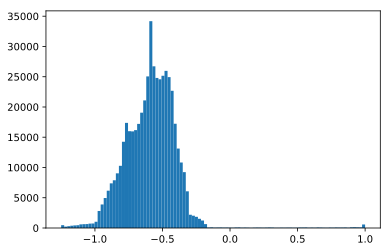

In [25]:
plt.hist(E_loc.detach().clamp(-1.25, 1).numpy(), bins=100);

In [26]:
scf_energy, E_loc.mean().item()

(-0.5904789926457445, -0.589744508266449)